In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import random
from scipy import stats
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Colab Notebooks/Intro to AI-520/Better Smarter Faster/"

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Intro to AI-520/Better Smarter Faster


In [ ]:
with open('Our Data/u_partial.pickle', 'rb') as f:
  utility = pickle.load(f)

In [ ]:
#create data

size = 50
reshape = []
for i in range(1, size+1):
  for j in range(1, size+1):
    belief_state = utility[(i-1,j-1)][0]
      
    preyProb = np.array(belief_state)
    MaxPreyPos = float(np.argmax(preyProb))
    PreyProbMin = np.min(preyProb)
    PreyProbMax = np.max(preyProb)
    PreyProbMean = np.mean(preyProb)
    PreyProbMode = stats.mode(preyProb)[0]

    reshape.append([float(i), float(j), MaxPreyPos, PreyProbMin, PreyProbMax, PreyProbMean, PreyProbMode, float(utility[i-1][j-1])])
  

In [ ]:
#Just for Visualization of Features of the Data
data = pd.DataFrame(reshape, columns = ['Agent','Predator', 'MaxPreyPos', 'PreyProbMin', 'PreyProbMax', 'PreyProbMean', 'PreyProbMode', 'Utility'])
data.head()

,Agent,Predator,MaxPreyPos,PreyProbMin,PreyProbMax,PreyProbMean,PreyProbMode,Utility
0,1.0,1.0,4.0,0.0,0.933721,0.02,[0.0],17.0
1,1.0,2.0,13.0,0.0,0.814050,0.02,[0.0],17.0
2,1.0,3.0,2.0,0.0,0.927228,0.02,[0.0],16.0
3,1.0,4.0,28.0,0.0,0.583193,0.02,[0.0],25.0
4,1.0,5.0,37.0,0.0,0.803965,0.02,[0.0],12.0


In [ ]:
vec = np.array(reshape)
m,n = vec.shape
np.random.shuffle(vec)
print(m,n)

# training_split = math.ceil(m*0.8)
#Training split
training = vec[0:2000].T
x_train = training[0:n-1].T
y_train = training[n-1].T

#Testing split
testing = vec[2001: m]
x_test = testing[0:n-1]
y_test = testing[n-1]

2500 8


<ipython-input-64-5b9707695c87>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vec = np.array(reshape)


In [ ]:
data = pd.DataFrame(x_train)
data.head()

,0,1,2,3,4,5,6
0,16.0,38.0,23.0,0.0,0.590572,0.02,[0.0]
1,42.0,35.0,0.0,0.0,0.692585,0.02,[0.0]
2,41.0,27.0,4.0,0.0,0.932666,0.02,[0.0]
3,25.0,6.0,32.0,0.0,0.419042,0.02,[0.0]
4,15.0,35.0,36.0,0.0,0.471157,0.02,[0.0]


In [ ]:
data = pd.DataFrame(y_train)
data.head()

,0
0,24.0
1,27.0
2,28.0
3,21.0
4,12.0


In [ ]:
examples , features = x_train.shape
examples

2000

In [ ]:
class ForwardPass:
  def __init__(self, input_size, output_size):
    self.input_size = input_size
    self.output_size = output_size
    self.weights = np.random.randn(input_size, output_size) / np.sqrt(100*(input_size + output_size))
    self.bias = np.random.randn(1, output_size) / np.sqrt(100*(input_size + output_size))

  def forwardProp(self, input):
    self.input = input
    return np.dot(input, self.weights) + self.bias

  def backwardProp(self, output_error, learning_rate):
    input_error = np.dot(output_error, self.weights.T)
    weights_error = np.dot(self.input.T, output_error)
    # bias_error = output_error
    
    self.weights -= learning_rate * weights_error
    self.bias -= learning_rate * output_error
    return input_error

In [ ]:
class ActivationFunction:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forwardProp(self, input):
        self.input = input
        return self.activation(input)
    
    def backwardProp(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)

In [ ]:
def leaky_ReLU(x):
  #vanilla relu
  # return np.maximum(0, Z)
  return np.where(x > 0, x, x * 0.01)  

def leaky_ReLU_prime(x):
  #vanilla relu
  # return Z > 0
  return np.where(x > 0, 1, 0.01)  

In [ ]:
def mse(y_true, y_pred):
  return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
  return 2 * (y_pred - y_true) / y_pred.size

In [ ]:
#2 hidden layers neural network
neural_network = [
  ForwardPass(7, 20),
  ActivationFunction(leaky_ReLU, leaky_ReLU_prime),
  ForwardPass(20, 20),
  ActivationFunction(leaky_ReLU, leaky_ReLU_prime),
  ForwardPass(20, 20),
  ActivationFunction(leaky_ReLU, leaky_ReLU_prime),
  ForwardPass(20, 10),
  ActivationFunction(leaky_ReLU, leaky_ReLU_prime),
  ForwardPass(10, 1),
  ActivationFunction(leaky_ReLU, leaky_ReLU_prime)
]
errors = []

epochs = 500
learning_rate = 0.1

for epoch in range(epochs):
  error = 0
  for x, y_true in zip(x_train, y_train):
    # forward
    x = x.reshape((1, x.shape[0]))
    output = x
    for layer in neural_network:
      output = layer.forwardProp(output)

    error += mse(y_true, output)

    # backward
    output_error = mse_prime(y_true, output)
    for layer in reversed(neural_network):
      output_error = layer.backwardProp(output_error, learning_rate)
  
  error /= len(x_train)
  print('%d/%d, error=%f' % (epoch + 1, epochs, error))
  errors.append(error)

Loss for iteration 0 => 578.099
Loss for iteration 1 => 572.3180100000001
Loss for iteration 2 => 566.5948299
Loss for iteration 3 => 560.9288816010001
Loss for iteration 4 => 555.31959278499
Loss for iteration 5 => 549.7663968571402
Loss for iteration 6 => 544.2687328885688
Loss for iteration 7 => 538.8260455596832
Loss for iteration 8 => 533.4377851040863
Loss for iteration 9 => 528.1034072530455
Loss for iteration 10 => 522.822373180515
Loss for iteration 11 => 517.5941494487098
Loss for iteration 12 => 512.4182079542227
Loss for iteration 13 => 507.2940258746805
Loss for iteration 14 => 502.22108561593365
Loss for iteration 15 => 497.1988747597743
Loss for iteration 16 => 492.2268860121766
Loss for iteration 17 => 487.3046171520548
Loss for iteration 18 => 482.4315709805342
Loss for iteration 19 => 477.6072552707289
Loss for iteration 20 => 472.83118271802164
Loss for iteration 21 => 468.1028708908414
Loss for iteration 22 => 463.421842181933
Loss for iteration 23 => 458.7876237601

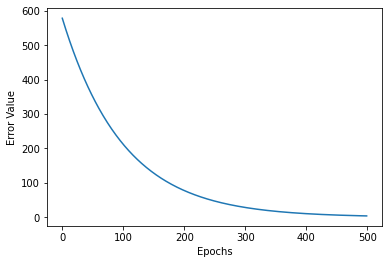

In [ ]:
X = np.arange(len(errors))
Y = np.array(errors)
plt.xlabel("Epochs")  
plt.ylabel("Error Value")  
plt.plot(X,Y)
plt.show()

In [ ]:
def predict(X):
  for layer in neural_network:
    output = layer.forwardProp(output)
  return output

In [ ]:
V_partial= {}
for i in range(2500):
  X = data.iloc[i,:-1].values
  X = np.expand_dims(X,axis = 1)
  y = predict(X)
  V_partial[(X[0][0],X[1][0],X[2][0])] = y[0][0]

In [ ]:
with open("Our Data/v_partial.pickle", "wb") as f:
  pickle.dump(V_partial,f)